# Tutorial: Scanpy + Dask-AnnData

This notebook demonstrates converting a TileDB-SOMA [ExperimentAxisQuery] to an [anndata] whose `X` matrix is a [Dask Array], and then running [Scanpy]'s [distributed HVG and PCA implementations][scanpy dask nb] on it.

[ExperimentAxisQuery]: https://tiledbsoma.readthedocs.io/en/stable/python-tiledbsoma-experimentaxisquery.html
[anndata]: https://anndata.readthedocs.io/en/stable/
[Dask Array]: https://docs.dask.org/en/stable/array.html
[Scanpy]: https://scanpy.readthedocs.io/en/stable/
[scanpy dask nb]: https://scanpy.readthedocs.io/en/stable/tutorials/experimental/dask.html

In addition to [dask], [distributed], and [tiledbsoma], this notebook requires [dask-ml] to be installed; here are some known-good pins:

```bash
pip install dask==2025.2.0 distributed==2025.2.0 dask-ml==2024.4.4 scanpy==1.11.0 scikit-learn==1.5.2
```

[dask]: https://pypi.org/project/dask/
[distributed]: https://pypi.org/project/distributed/
[tiledbsoma]: https://pypi.org/project/tiledbsoma/
[dask-ml]: https://pypi.org/project/dask-ml/

The first cell below contains [Papermill] parameters, which can be overridden when running this notebook programmatically, e.g.:

```bash
name=tutorial_scanpy_pca_dask
papermill -p tissue lung -p dask_chunk_size 200_000 $name.ipynb $name-lung_200k.ipynb
```

[Papermill]: https://papermill.readthedocs.io/en/latest/

In [1]:
from os import cpu_count

from psutil import virtual_memory

available_mem = virtual_memory().available

# Census
measurement_name = "RNA"             # CELLxGENE Census measurement name
layer = "raw"                        # Read "raw" transcript counts
census = "2025-01-30"                # Recent CELLxGENE Census version
tissue = "blood"                     # Query cells matching this "tissue_general" value
var_filter = None                    # Select all genes, by default

# Dask
dask_chunk_size = 100_000            # Number of "X" matrix rows per Dask task
worker_mem_allowance = 10 * 2**30    # 100k cell-rows per chunk uses about 10GiB in each worker
n_dask_procs = max(2, min(           # Number of Dask worker processes to spawn
    cpu_count(),
    available_mem // worker_mem_allowance,
))
dask_disable_worker_mem_mgmt = True  # Disable spilling and worker pausing/terminating; they tend to harm more than help
dask_graph_warn_size = "50MB"        # Relax default (10MB) "Sending large graph" warning threshold ("distributed.admin.large-graph-warning-threshold" config key)
dashboard_port = 8787                # Port for the Dask web UI (for following jobs in real-time)

# Scanpy
hvg_inplace = True                   # Scanpy HVG: "inplace=True" by default
hvg_subset = False                   # Scanpy HVG: "subset=False" by default

## Open experiment, initialize query

Open the [CELLxGENE Census] [Experiment]:

[CELLxGENE Census]: https://chanzuckerberg.github.io/cellxgene-census/
[Experiment]: https://tiledbsoma.readthedocs.io/en/stable/python-tiledbsoma-experiment.html

In [2]:
import scanpy as sc
from somacore import AxisQuery

from tiledbsoma import Experiment, SOMATileDBContext

tiledb_config = {
    "vfs.s3.no_sign_request": "true",
    "vfs.s3.region": "us-west-2",
}
exp_uri = f"s3://cellxgene-census-public-us-west-2/cell-census/{census}/soma/census_data/homo_sapiens"
exp = Experiment.open(
    exp_uri,
    context=SOMATileDBContext(tiledb_config=tiledb_config),
)
exp

<Experiment 's3://cellxgene-census-public-us-west-2/cell-census/2025-01-30/soma/census_data/homo_sapiens' (open for 'r') (2 items)
    'ms': 's3://cellxgene-census-public-us-west-2/cell-census/2025-01-30/soma/census_data/homo_sapiens/ms' (unopened)
    'obs': 's3://cellxgene-census-public-us-west-2/cell-census/2025-01-30/soma/census_data/homo_sapiens/obs' (unopened)>

Set up query for cells from the given tissue:

In [3]:
%%time
obs_filter = "is_primary_data == True"  # Deduplicate / only fetch primary representations of cells
if tissue:
    obs_filter = f'tissue_general == "{tissue}" and {obs_filter}'
query = exp.axis_query(
    measurement_name=measurement_name,
    obs_query=AxisQuery(value_filter=obs_filter) if obs_filter else None,
    var_query=AxisQuery(value_filter=var_filter) if var_filter else None,
)

CPU times: user 13.9 ms, sys: 5.08 ms, total: 19 ms
Wall time: 172 ms


Check the number of cells responsive to the query:

In [4]:
%%time
query.n_obs

CPU times: user 4.43 s, sys: 2.01 s, total: 6.44 s
Wall time: 1.07 s


11220002

## Initialize Dask
Create a cluster of local processes:

In [5]:
import dask
import dask_ml  # Used by `sc.pp.pca` later, fail early here if not installed  # noqa: F401
from dask.distributed import Client, LocalCluster

if dask_disable_worker_mem_mgmt:
    # Dask spilling and worker pause/terminate logic mostly interferes with our usage.
    # It doesn't take into account available swap space and, once workers begin to spill
    # or pause, the HVG/PCA jobs below never recover.
    dask.config.set(
        {
            # "distributed.worker.memory.target": 0.7,
            "distributed.worker.memory.spill": False,
            "distributed.worker.memory.pause": False,
            "distributed.worker.memory.terminate": False,
        }
    )

if dask_graph_warn_size:
    # Relax default (10MB) "Sending large graph" warning threshold
    dask.config.set({ "distributed.admin.large-graph-warning-threshold": dask_graph_warn_size })

if dask_chunk_size:
    cluster = LocalCluster(
        n_workers=n_dask_procs,
        threads_per_worker=1,  # Performance is better with just one thread per worker process
        dashboard_address=f":{dashboard_port}",
    )
    print(f"{n_dask_procs=}")
    client = Client(cluster)
else:
    dask_chunk_size = None
    client = None
client

n_dask_procs=24


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 24
Total threads: 24,Total memory: 246.55 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46605,Workers: 24
Dashboard: http://127.0.0.1:8787/status,Total threads: 24
Started: Just now,Total memory: 246.55 GiB
Comm: tcp://127.0.0.1:34907,Total threads: 1
Dashboard: http://127.0.0.1:41643/status,Memory: 10.27 GiB
Nanny: tcp://127.0.0.1:44377,


It's recommended to use one worker thread per Dask process (`threads_per_worker=1` above). Performance (wall-clock and memory use) suffers when more than one Dask worker thread runs in the same Dask worker process.

It's also encouraged to open the dashboard at [127.0.0.1:8787/status](http://127.0.0.1:8787/status), to follow along with tasks, progress, and memory use in real-time. Here's an example screenshot of that UI, from a completed run of this notebook:

![Screenshot of Dask web UI after running this notebook](https://raw.githubusercontent.com/single-cell-data/TileDB-SOMA/bd3ed125/apis/python/notebooks/img/dask-dashboard.png)

## Convert `query` to Dask-backed anndata

In [6]:
%%time
adata = query.to_anndata(
    layer,
    dask=dict(
        chunk_size=dask_chunk_size,
        tiledb_config=tiledb_config,
    ),
)
adata

CPU times: user 26.9 s, sys: 17.3 s, total: 44.2 s
Wall time: 22.5 s


AnnData object with n_obs × n_vars = 11220002 × 61888
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'observation_joinid', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_type', 'feature_length', 'nnz', 'n_measured_obs'

The `X` matrix is a [Dask Array]:

[Dask Array]: https://docs.dask.org/en/stable/array.html

In [7]:
print(type(adata.X))
adata.X

<class 'dask.array.core.Array'>


dask.array<sparse_chunk, shape=(11220002, 61888), dtype=float32, chunksize=(100000, 61888), chunktype=scipy.csr_matrix>

## Scanpy preprocessing

PCA uses normalized cell counts, and `log1p` values:

In [8]:
%%time
sc.pp.normalize_total(adata)

CPU times: user 392 ms, sys: 25.3 ms, total: 417 ms
Wall time: 356 ms


In [9]:
%%time
sc.pp.log1p(adata)

CPU times: user 5.75 ms, sys: 0 ns, total: 5.75 ms
Wall time: 5.58 ms


## Scanpy HVG

In [10]:
%%time
hvg = sc.pp.highly_variable_genes(adata, inplace=hvg_inplace, subset=hvg_subset)
hvg

/home/ubuntu/.pyenv/versions/3.11.8/lib/python3.11/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 86.36 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 43.2 s, sys: 28.7 s, total: 1min 11s
Wall time: 1min 46s


## Scanpy PCA

**NOTE:** it's important to run HVG before PCA, so that PCA will only operate on the highly-variable genes. Otherwise, it will run on all ≈60k genes, and use intractable amounts of memory and compute.

In [11]:
%%time
sc.pp.pca(adata)

/home/ubuntu/.pyenv/versions/3.11.8/lib/python3.11/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 86.39 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 2min 38s, sys: 40.6 s, total: 3min 19s
Wall time: 5min 15s


In [12]:
%%time
adata.obsm["X_pca"] = adata.obsm["X_pca"].compute()

/home/ubuntu/.pyenv/versions/3.11.8/lib/python3.11/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 86.94 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 48 s, sys: 23.1 s, total: 1min 11s
Wall time: 1min 52s


## Subset cell types, plot

In [13]:
t10 = adata.obs.cell_type.value_counts().iloc[:10]
a10 = adata[adata.obs.cell_type.isin(t10.index)]
a10

View of AnnData object with n_obs × n_vars = 7147176 × 61888
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'observation_joinid', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_type', 'feature_length', 'nnz', 'n_measured_obs', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

/home/ubuntu/.pyenv/versions/3.11.8/lib/python3.11/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/ubuntu/.pyenv/versions/3.11.8/lib/python3.11/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


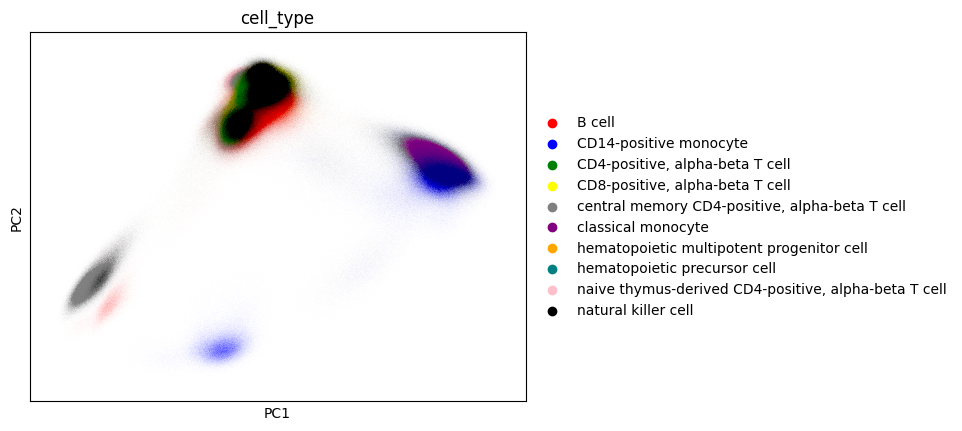

CPU times: user 1min 53s, sys: 5.85 s, total: 1min 59s
Wall time: 1min 56s


In [14]:
%%time
sc.pl.pca(a10, color="cell_type", palette=["red", "blue", "green", "yellow", "grey", "purple", "orange", "teal", "pink", "black"])